#### Assignment 4 - Alex Ceccotti - 790497

Dal momento che l'assignment è stato sviluppato in google colab, è stato necessario caricare le credenziali di Kaggle e posizionarle nell'opportuna directory. La guida all'utilizzo della API di Kaggle è presente al seguente link: https://github.com/Kaggle/kaggle-api. Viene poi fatto il download del dataset delle icone (lo stesso dell'assignment 3) direttamente da Kaggle tramite API.

In [0]:
!mkdir /root/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d danhendrycks/icons50

 95% 82.0M/86.7M [00:01<00:00, 56.8MB/s]
100% 86.7M/86.7M [00:01<00:00, 74.6MB/s]



Il dataset viene poi decompresso e posizionato nella cartella my_data, che conterrà dunque 50 sottocartelle, ognuna della quali conterrà le immagini di una data classe.

In [0]:
import zipfile
with zipfile.ZipFile('icons50.zip', 'r') as zip_ref:
    zip_ref.extractall('my_folder')

In [0]:
with zipfile.ZipFile('my_folder/Icons-50.zip', 'r') as zip_ref:
    zip_ref.extractall('Icons-50')

In [0]:
!cp -r Icons-50/Icons-50 my_data
!rm icons50.zip
!rm -r my_folder
!rm -r Icons-50
!rm my_data/README.txt

In [0]:
import numpy as np
import pandas as pd
from time import time
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from random import shuffle

from keras.applications import vgg19
from keras.preprocessing import image as kimage
from keras.models import Model, load_model
from keras.layers import Dense
from keras import optimizers


def load_data(directory, maximages=-1):
    base_path = './'+directory+'/'
    labels = []
    features = []
    for di,d in enumerate(sorted(os.listdir(base_path))):
        for fi,f in enumerate(sorted(os.listdir(base_path + d + '/'))):
            if f.endswith('.png') and (fi<maximages or maximages==-1):
                image = kimage.load_img(base_path + d + '/' + f, target_size=(224, 224))
                features.append(image)
                labels.append(di)
        print("Caricate " + str(fi+1) + " immagini dalla cartella numero " + str(di) + " (" + d + ")")
        fi = -1
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=1)
    return X_train, X_val, X_test, pd.get_dummies(y_train).as_matrix(), pd.get_dummies(y_val).as_matrix(), pd.get_dummies(y_test).as_matrix()

La funzione load_data carica le immagini in una lista, che viene poi splittata in training, validation e test set. In questa fase le immagini non sono ancora state trasformate in array e non è stato ancora fatto alcun genere di preprocessing.

In [0]:
X_train, X_val, X_test, y_train, y_val, y_test = load_data('my_data', maximages=-1)

Caricate 76 immagini dalla cartella numero 0 (airplane)
Caricate 392 immagini dalla cartella numero 1 (arrow_directions)
Caricate 192 immagini dalla cartella numero 2 (ball)
Caricate 100 immagini dalla cartella numero 3 (biking)
Caricate 229 immagini dalla cartella numero 4 (bird)
Caricate 90 immagini dalla cartella numero 5 (blade)
Caricate 289 immagini dalla cartella numero 6 (boat)
Caricate 208 immagini dalla cartella numero 7 (books)
Caricate 312 immagini dalla cartella numero 8 (building)
Caricate 160 immagini dalla cartella numero 9 (bunny_ears)
Caricate 105 immagini dalla cartella numero 10 (cartwheeling)
Caricate 417 immagini dalla cartella numero 11 (clock)
Caricate 141 immagini dalla cartella numero 12 (cloud)
Caricate 63 immagini dalla cartella numero 13 (disk)
Caricate 238 immagini dalla cartella numero 14 (drinks)
Caricate 429 immagini dalla cartella numero 15 (emotion_face)
Caricate 119 immagini dalla cartella numero 16 (envelope)
Caricate 455 immagini dalla cartella nume

In [0]:
print(y_train.shape, y_val.shape, y_test.shape)

(6300, 50) (700, 50) (3000, 50)


Vengono caricati i pesi della rete VGG19 con average pooling escludendo gli strati fully connected.

In [0]:
net = vgg19.VGG19(include_top=False, weights='imagenet', pooling='avg')

Vengono dunque aggiunti due strati fully connected con 1024 neuroni ciascuno e con funzione di attivazione relu. I pesi di questi strati andranno tunati, mentre quelli caricati precedentemente vengono fissati. Infine, viene aggiunto uno strato con 50 neuroni (uno per classe) con funzione di attivazione softmax. Viene utilizzato l'ottimizzatore "adam" con learning rate pari a 0.0001 e funzione di perdita "categorical crossentropy".

In [0]:
for layer in net.layers:
    layer.trainable = False
    
x = net.output
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
pred = Dense(y_train.shape[1], activation='softmax')(x)

my_net = Model(inputs=net.input, outputs=pred)

adam = optimizers.Adam(lr=0.0001)
my_net.compile(optimizer=adam, loss='categorical_crossentropy')

Viene eseguito il preprocessing delle immagini di validation e di test necessario per passare tali immagini alla rete VGG19.

In [0]:
X_val_preproc = []
for image in X_val:
    image = kimage.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = vgg19.preprocess_input(image)
    X_val_preproc.append(image)
X_val_preproc = np.array(X_val_preproc).reshape(-1, 224, 224, 3)

In [0]:
X_test_preproc = []
for image in X_test:
    image = kimage.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = vgg19.preprocess_input(image)
    X_test_preproc.append(image)
X_test_preproc = np.array(X_test_preproc).reshape(-1, 224, 224, 3)

Viene trainata la rete passando batch di 64 immagini alla volta. Ad ogni batch viene fatto il preprocessing di VGG19 trasformando inoltre le immagini del batch in array. Questa procedura è stata fatta per ogni batch e non tutta in una volta per motivi di spazio di memoria. Alla fine di ogni epoca, viene valutata la loss sul validation set.

In [0]:
batch_size=128
for i in range(25):
    for j in range((len(X_train)//batch_size)+1):
        batch = X_train[batch_size*j:batch_size*(j+1)]
        y = y_train[batch_size*j:batch_size*(j+1),]
        x = []
        for image in batch:
            image = kimage.img_to_array(image)
            image = np.expand_dims(image, axis=0)
            image = vgg19.preprocess_input(image)
            x.append(image.reshape(224,224,3))
        x = np.array(x)
        my_net.train_on_batch(x, y)
    print("Epoca " + str(i+1) + " finita. Loss sul validation set: ")
    print(my_net.evaluate(x=X_val_preproc, y=y_val, batch_size=128))

Epoca 1 finita. Loss sul validation set: 
700/700 [==============================] - 9s 12ms/step
1.1243261752809797
Epoca 2 finita. Loss sul validation set: 
700/700 [==============================] - 7s 11ms/step
0.580847282750266
Epoca 3 finita. Loss sul validation set: 
700/700 [==============================] - 7s 11ms/step
0.43630905049187796
Epoca 4 finita. Loss sul validation set: 
700/700 [==============================] - 7s 11ms/step
0.3658160594531468
Epoca 5 finita. Loss sul validation set: 
700/700 [==============================] - 7s 11ms/step
0.32145916053227014
Epoca 6 finita. Loss sul validation set: 
700/700 [==============================] - 7s 11ms/step
0.2940525221824646
Epoca 7 finita. Loss sul validation set: 
700/700 [==============================] - 7s 11ms/step
0.27871462532452174
Epoca 8 finita. Loss sul validation set: 
700/700 [==============================] - 7s 11ms/step
0.26640990206173487
Epoca 9 finita. Loss sul validation set: 
700/700 [==========

Dopo aver allenato la rete sui dati di training per 25 epoche, vengono fatte le predizioni sul test set.

In [0]:
y_pred = my_net.predict(X_test_preproc, batch_size=128)

Gli output della rete sono dei vettori con 50 elementi. L'indice dell'elemento con valore maggiore sarà dunque la classe predetta.

In [0]:
my_pred = np.argmax(y_pred, axis=1)
my_true = np.argmax(y_test, axis=1)

In [0]:
print("Report di classificazione:")
print(classification_report(my_true, my_pred))

Report di classificazione:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        23
           1       0.92      0.98      0.95       121
           2       0.93      0.85      0.89        61
           3       1.00      1.00      1.00        29
           4       0.94      0.86      0.90        70
           5       0.81      0.74      0.77        23
           6       0.94      0.94      0.94        90
           7       0.95      0.92      0.93        61
           8       0.94      0.96      0.95        81
           9       0.97      0.97      0.97        58
          10       1.00      1.00      1.00        30
          11       0.97      0.99      0.98       131
          12       0.91      0.96      0.93        51
          13       0.93      0.81      0.87        16
          14       0.90      0.86      0.88        71
          15       0.97      0.99      0.98       114
          16       0.96      0.89      0.93        28


Matrice di confusione:


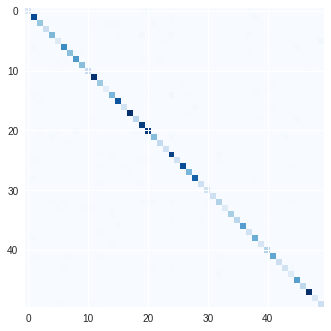

In [0]:
print("Matrice di confusione:")
cm = confusion_matrix(my_true, my_pred)
plt.imshow(cm, cmap='Blues')

In [0]:
print("Accuracy: " + str(accuracy_score(my_true, my_pred)))

Accuracy: 0.9466666666666667


Si ottiene un F1-score pari a 0.95 e un accuaracy pari a 0.947.
